# PCA

In [1]:
# necessary libraries

# %pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# read data to DataFrame
import pandas as pd
import numpy as np

# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# pipeline
from sklearn.pipeline import Pipeline

# model selection
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score,  classification_report, confusion_matrix, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin

# decomposition PCA
from sklearn.decomposition import IncrementalPCA, TruncatedSVD

# classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

#learning
from sklearn.model_selection import learning_curve

In [2]:
# load data
PATH_TO_DATA = './simplesentiment/'
files = ['products_sentiment_train.tsv', 'products_sentiment_test.tsv']
train =  pd.read_csv(PATH_TO_DATA+files[0], sep = '\t', header = None, names = ['text', 'target'])
# train, taget, test
X = train.text
y = train.target

# 2D

In [3]:
# data transformer - vectorizer
from nltk.tokenize.casual import casual_tokenize
vectorizer = TfidfVectorizer(
    ngram_range=(2, 3),
    #     min_df = 2,
    tokenizer=casual_tokenize,
    analyzer = 'char_wb',
    sublinear_tf=False)

svd = TruncatedSVD(n_components=2, n_iter=100)

transformer = Pipeline(steps=[('vectorizer', vectorizer), ('decomposition',
                                                           svd)])

In [4]:
# split data
def split_data(X, y, rs):
    test_portion = 0.33
    return train_test_split(X,
                            y,
                            test_size=test_portion,
                            random_state=int(rs),
                            shuffle=True,
                            stratify=y)

# data transformation
def transform_data(train, validation, t):
    t.fit(train)
    return t.transform(train), t.transform(validation)

In [5]:
# transformation
Xt = transformer.fit_transform(X)

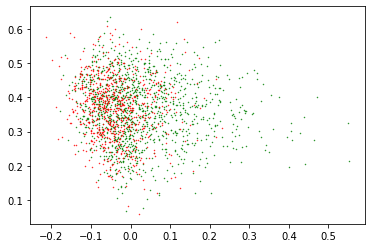

In [6]:
positive = Xt[y == 1]
negative = Xt[y == 0]
plt.scatter(positive[:, 1], positive[:, 0], color='green', s=0.2)
plt.scatter(negative[:, 1], negative[:, 0], color='red', s=0.2)

# 3D

In [7]:
# data transformer - vectorizer
from nltk.tokenize.casual import casual_tokenize
vectorizer = TfidfVectorizer(
    ngram_range=(2, 4),
    min_df = 2,
    tokenizer=casual_tokenize,
    analyzer = 'char_wb',
    sublinear_tf=False)

svd = TruncatedSVD(n_components=3, n_iter=100)

transformer = Pipeline(steps=[('vectorizer', vectorizer), ('decomposition',
                                                           svd)])

In [8]:
# transformation
Xt = transformer.fit_transform(X)

In [9]:
positive = Xt[y == 1]
negative = Xt[y == 0]

(-1, 1)

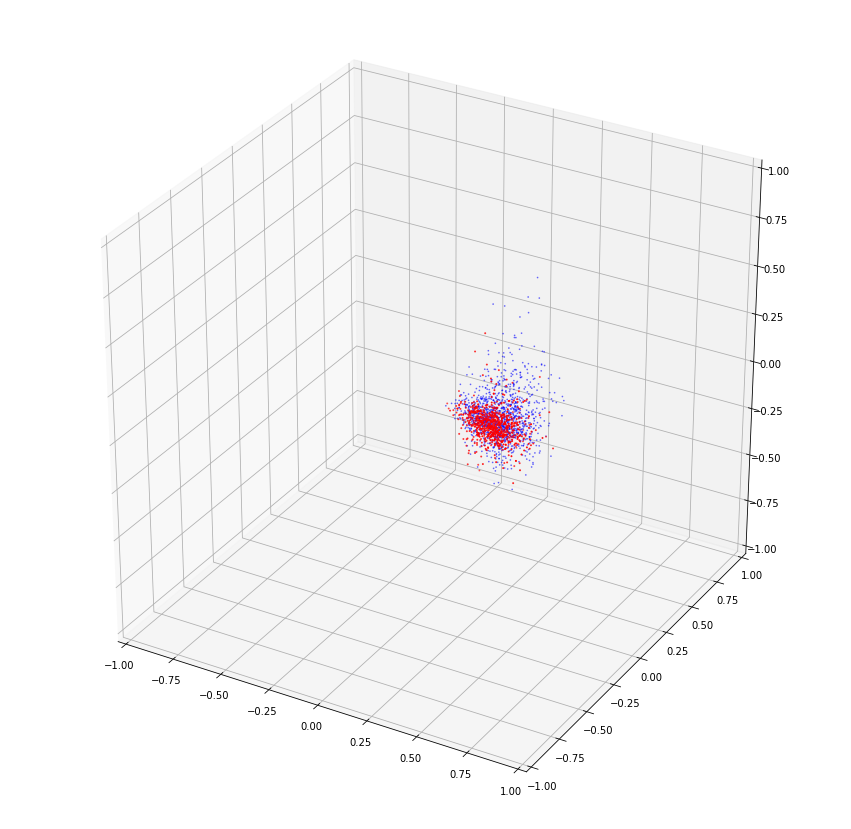

In [10]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positive[:, 0], positive[:, 1], positive[:, 2], color='blue', s=0.5, alpha = 0.5)
ax.scatter(negative[:, 0], negative[:, 1], negative[:, 2],color='red', s=1)
plt.xlim((-1, 1))
plt.ylim((-1, 1))
ax.set_zlim(-1, 1)

# Search opt. n_components by ROC_AUC

In [11]:
lda = LinearDiscriminantAnalysis(
    solver='eigen',
    shrinkage='auto'
)

In [15]:
from tqdm import tqdm

classifier = lda
r_seed = 22

# split data to train/validation sets
X_train, X_validation, y_train, y_val = split_data(X, y, r_seed)

scores = []
lim = 60
n_range = np.linspace(1, lim, lim).astype(int)
for n in tqdm(n_range):
    # decompositor
    svd = TruncatedSVD(n_components=n, n_iter=100)
    # transformer
    pipe = Pipeline(steps=[('vectorizer',
                            vectorizer), ('decomposition',
                                          svd), ('classifier', classifier)])
    # fit classifier with train data
    pipe.fit(X_train, y_train)
    # get predictions as probabilities [0..1]
    prob_scores = pipe.predict_proba(X_validation)[:, 1]
    score = roc_auc_score(y_val, prob_scores)
    scores.append(score)

plt.plot(n_range, scores)

In [57]:
 np.max(scores), n_range[np.argmax(scores)]

(0.7575757575757576, 40)

# Search opt. decision value

In [18]:
n_components = 40
r_seed = 15

(0.585, 0.7606060606060606)

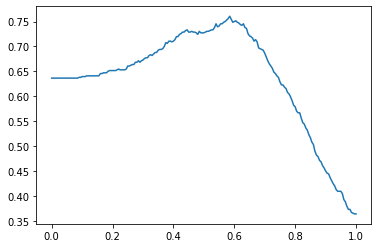

In [19]:
accuracies = []

# split data to train/validation sets
X_train, X_validation, y_train, y_val = split_data(X, y, r_seed)
# decompositor
svd = TruncatedSVD(n_components, n_iter=100)
# transformer
pipe = Pipeline(steps=[('vectorizer',
                        vectorizer), ('decomposition',
                                      svd), ('classifier', classifier)])
# fit classifier with train data
pipe.fit(X_train, y_train)
# get predictions as probabilities [0..1]
prob_scores = pipe.predict_proba(X_validation)[:, 1]
t_range = np.linspace(0, 1.0, 201)
for t in t_range:
    predictions = (prob_scores > t).astype(int)
    accuracies.append(accuracy_score(y_val, predictions))
    
plt.plot(t_range, accuracies)
decision_value = t_range[np.argmax(accuracies)]
decision_value, np.max(accuracies)

# Prove opt. n_components by decision value and accuracy

In [58]:
decision_value = 0.55
classifier = lda
r_seed = 12

100%|██████████| 60/60 [02:46<00:00,  2.78s/it]


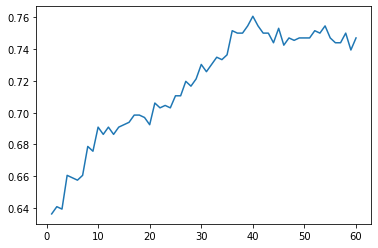

In [20]:
# split data to train/validation sets
X_train, X_validation, y_train, y_val = split_data(X, y, r_seed)

scores = []
lim = 60
n_range = np.linspace(1, lim, lim).astype(int)
for n in tqdm(n_range):
    # decompositor
    svd = TruncatedSVD(n_components=n, n_iter=100)
    # transformer
    pipe = Pipeline(steps=[('vectorizer',
                            vectorizer), ('decomposition',
                                          svd), ('classifier', classifier)])
    # fit classifier with train data
    pipe.fit(X_train, y_train)
    # get predictions as probabilities [0..1]
    prob_scores = pipe.predict_proba(X_validation)[:, 1]
    predictions = (prob_scores > decision_value).astype(int)
    score = accuracy_score(y_val, predictions)
    scores.append(score)
    
plt.plot(n_range, scores)

In [21]:
np.max(scores).round(2), n_range[np.argmax(scores)]

(0.76, 40)

# Learning curve

## Logistic Regression

In [35]:
classifier = LogisticRegression(random_state=0, C=5)
n_components = 40
decision_value = 0.55

In [27]:
%%time

# decompositor
svd = TruncatedSVD(n_components, n_iter=100)
# transformer
pipe = Pipeline(steps=[('vectorizer',
                        vectorizer), ('decomposition',
                                      svd), ('classifier', classifier)])
# fit classifier with train data
pipe.fit(X_train, y_train)
# get predictions as probabilities [0..1]
prob_scores = pipe.predict_proba(X_validation)[:, 1]
predictions = (prob_scores > decision_value).astype(int)

accuracy_score(y_val, predictions)

CPU times: user 3.63 s, sys: 432 ms, total: 4.06 s
Wall time: 3.47 s


0.7454545454545455

In [30]:
train_sizes, train_scores, test_scores = learning_curve(pipe,
                                                        X,
                                                        y,
                                                        n_jobs=4,
                                                        cv=5,
                                                        shuffle=True,
                                                        scoring=make_scorer(accuracy_score))

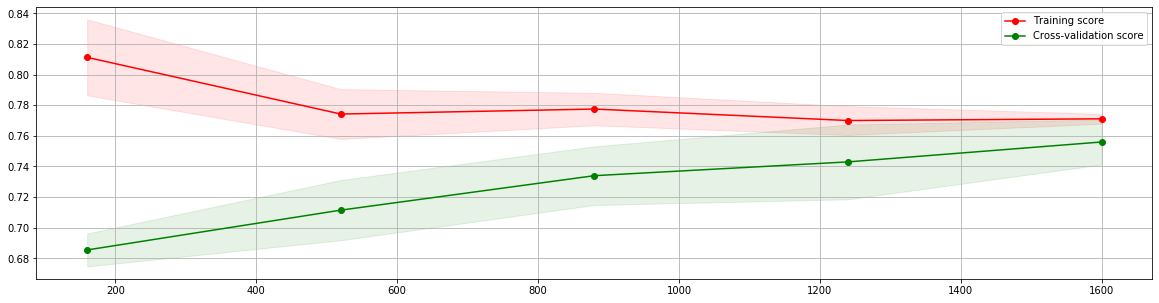

In [31]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

_, ax = plt.subplots(1, 1, figsize=(20, 5))
# Plot learning curve
ax.grid()
ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
ax.legend(loc="best")

(0.58, 0.753030303030303)

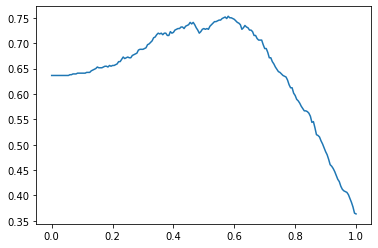

In [36]:
accuracies = []

# split data to train/validation sets
X_train, X_validation, y_train, y_val = split_data(X, y, r_seed)
# decompositor
svd = TruncatedSVD(n_components, n_iter=100)
# transformer
pipe = Pipeline(steps=[('vectorizer',
                        vectorizer), ('decomposition',
                                      svd), ('classifier', classifier)])
# fit classifier with train data
pipe.fit(X_train, y_train)
# get predictions as probabilities [0..1]
prob_scores = pipe.predict_proba(X_validation)[:, 1]
t_range = np.linspace(0, 1.0, 201)
for t in t_range:
    predictions = (prob_scores > t).astype(int)
    accuracies.append(accuracy_score(y_val, predictions))
    
plt.plot(t_range, accuracies)
decision_value = t_range[np.argmax(accuracies)]
decision_value, np.max(accuracies)

# Random Forest

In [41]:
classifier = RandomForestClassifier(n_jobs=-1,
                                    criterion='gini',
                                    max_depth=5,
                                    bootstrap=False,
                                    random_state=4,
                                    class_weight='balanced')
n_components = 40
decision_value = 0.45

In [42]:
%%time

# decompositor
svd = TruncatedSVD(n_components, n_iter=100)
# transformer
pipe = Pipeline(steps=[('vectorizer',
                        vectorizer), ('decomposition',
                                      svd), ('classifier', classifier)])
# fit classifier with train data
pipe.fit(X_train, y_train)
# get predictions as probabilities [0..1]
prob_scores = pipe.predict_proba(X_validation)[:, 1]
predictions = (prob_scores > decision_value).astype(int)

accuracy_score(y_val, predictions)

CPU times: user 4.71 s, sys: 514 ms, total: 5.23 s
Wall time: 4.14 s


0.6621212121212121

In [39]:
train_sizes, train_scores, test_scores = learning_curve(pipe,
                                                        X,
                                                        y,
                                                        n_jobs=4,
                                                        cv=5,
                                                        shuffle=True,
                                                        scoring=make_scorer(accuracy_score))

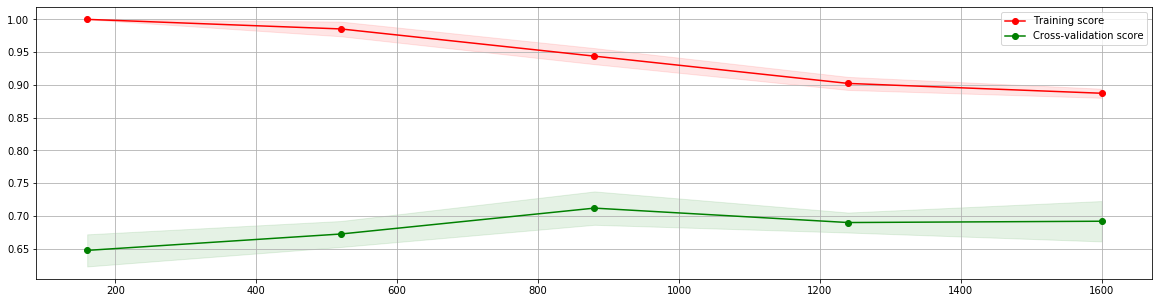

In [126]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

_, ax = plt.subplots(1, 1, figsize=(20, 5))
# Plot learning curve
ax.grid()
ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
ax.legend(loc="best")

(0.37, 0.703030303030303)

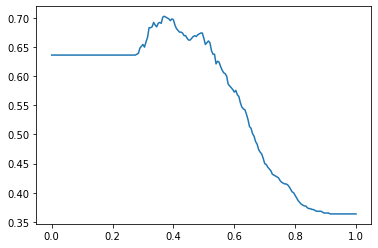

In [40]:
accuracies = []

# split data to train/validation sets
X_train, X_validation, y_train, y_val = split_data(X, y, r_seed)
# decompositor
svd = TruncatedSVD(n_components, n_iter=100)
# transformer
pipe = Pipeline(steps=[('vectorizer',
                        vectorizer), ('decomposition',
                                      svd), ('classifier', classifier)])
# fit classifier with train data
pipe.fit(X_train, y_train)
# get predictions as probabilities [0..1]
prob_scores = pipe.predict_proba(X_validation)[:, 1]
t_range = np.linspace(0, 1.0, 201)
for t in t_range:
    predictions = (prob_scores > t).astype(int)
    accuracies.append(accuracy_score(y_val, predictions))
    
plt.plot(t_range, accuracies)
decision_value = t_range[np.argmax(accuracies)]
decision_value, np.max(accuracies)

## SGD LogisticRegression

In [85]:
classifier = SGDClassifier(n_jobs=-1, random_state=3, class_weight='balanced', loss = 'log')

In [86]:
%%time

# decompositor
n_components = 180
svd = TruncatedSVD(n_components, n_iter=100)

# transformer
transformer = Pipeline(steps=[('vectorizer',
                               vectorizer), ('decomposition', svd)])

classifier = Pipeline([('transformer', transformer),('classifier', classifier)])
classifier.fit(X, y)

probabilities = classifier.predict_proba(X)[:, 1]

predictions = (probabilities > decision_value).astype(int)
accuracy_score(y, predictions)

CPU times: user 18.6 s, sys: 1.14 s, total: 19.7 s
Wall time: 5.19 s


0.7995

In [87]:
train_sizes, train_scores, test_scores = learning_curve(classifier,
                                                        X,
                                                        y,
                                                        n_jobs=4,
                                                        cv=5,
                                                        shuffle=True,
                                                        scoring=make_scorer(accuracy_score))

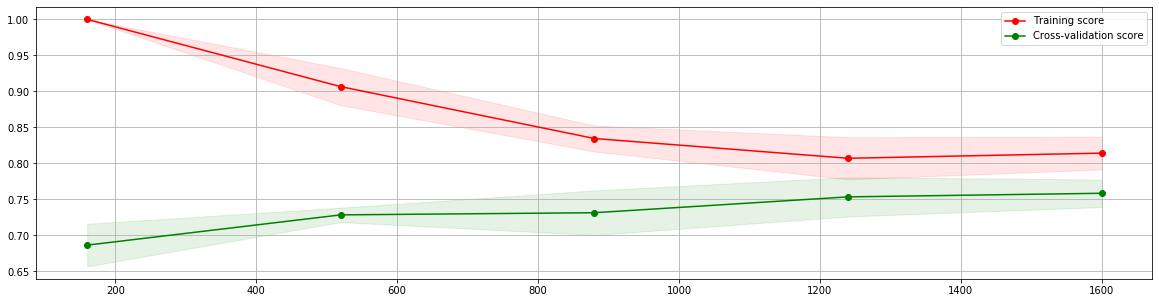

In [88]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

_, ax = plt.subplots(1, 1, figsize=(20, 5))
# Plot learning curve
ax.grid()
ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
ax.legend(loc="best")

(0.43, 0.7681818181818182)

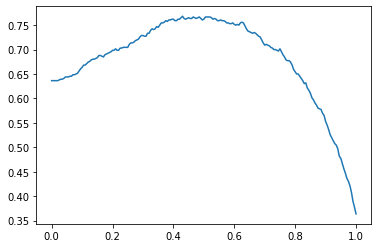

In [89]:
accuracies = []

r_seed = 22
# split data to train/validation sets
X_train, X_validation, y_train, y_val = split_data(X, y, r_seed)

# fit classifier with train data
classifier.fit(X_train, y_train)
# get predictions as probabilities [0..1]
prob_scores = classifier.predict_proba(X_validation)[:, 1]
t_range = np.linspace(0, 1.0, 201)
for t in t_range:
    predictions = (prob_scores > t).astype(int)
    accuracies.append(accuracy_score(y_val, predictions))
    
plt.plot(t_range, accuracies)
decision_value = t_range[np.argmax(accuracies)]
decision_value, np.max(accuracies)

## SVM

In [128]:
from sklearn.svm import SVC

classifier = SVC(kernel = 'rbf', random_state=3, class_weight='balanced', probability = True)

In [129]:
%%time

# decompositor
n_components = 180
svd = TruncatedSVD(n_components, n_iter=100)

# transformer
transformer = Pipeline(steps=[('vectorizer',
                               vectorizer), ('decomposition', svd)])

classifier = Pipeline([('transformer', transformer),('classifier', classifier)])
classifier.fit(X, y)

probabilities = classifier.predict_proba(X)[:, 1]

predictions = (probabilities > decision_value).astype(int)
accuracy_score(y, predictions)

CPU times: user 22.6 s, sys: 1.12 s, total: 23.7 s
Wall time: 9.66 s


0.9465

In [130]:
train_sizes, train_scores, test_scores = learning_curve(classifier,
                                                        X,
                                                        y,
                                                        n_jobs=4,
                                                        cv=5,
                                                        shuffle=True,
                                                        scoring=make_scorer(accuracy_score))

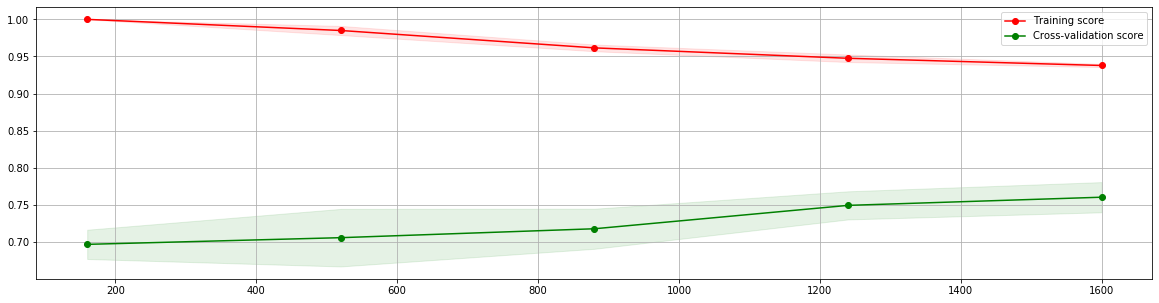

In [131]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

_, ax = plt.subplots(1, 1, figsize=(20, 5))
# Plot learning curve
ax.grid()
ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
ax.legend(loc="best")

(0.435, 0.7696969696969697)

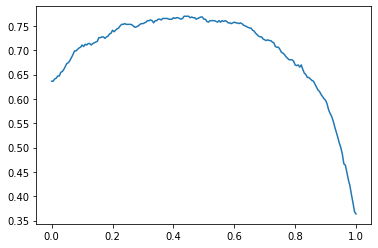

In [136]:
accuracies = []

r_seed = 22
# split data to train/validation sets
X_train, X_validation, y_train, y_val = split_data(X, y, r_seed)

# fit classifier with train data
classifier.fit(X_train, y_train)
# get predictions as probabilities [0..1]
prob_scores = classifier.predict_proba(X_validation)[:, 1]
t_range = np.linspace(0, 1.0, 201)
for t in t_range:
    predictions = (prob_scores > t).astype(int)
    accuracies.append(accuracy_score(y_val, predictions))
    
plt.plot(t_range, accuracies)
decision_value = t_range[np.argmax(accuracies)]
decision_value, np.max(accuracies)